In [1]:
import arepo
import h5py as h5
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm as tqdm
import matplotlib as mpl

from numba import njit

from joblib import Parallel, delayed
import pickle

In [2]:
basepath = '/n/holylfs05/LABS/hernquist_lab/Users/abeane/GSEgas/'

In [73]:
Naidu_idx = 1600//20
arepo_idx = 1600

In [74]:
sn = {}
sn['Naidu21'] = {}

sn['Naidu21']['lo'] = {}
sn['Naidu21']['lo'][0] = arepo.Snapshot('/n/holystore01/LABS/conroy_lab/Lab/rnaidu/sims/'+
                                        'z2merger_M1_UM/grid/129_129_50_pro_165/snapshot_000')
sn['Naidu21']['lo'][Naidu_idx] = arepo.Snapshot('/n/holystore01/LABS/conroy_lab/Lab/rnaidu/sims/'+
                                          'z2merger_M1_UM/grid/129_129_50_pro_165/snapshot_'+str(Naidu_idx).zfill(3))
# sn['Naidu21']['lo'][500] = arepo.Snapshot('/n/holystore01/LABS/conroy_lab/Lab/rnaidu/sims/'+
                                          # 'z2merger_M1_UM/grid/129_129_50_pro_165/snapshot_500')
print('Naidu21 times')
for idx in sn['Naidu21']['lo'].keys():
    print(idx, sn['Naidu21']['lo'][idx].Time)

# sn['Naidu21']['hi'] = {}
# sn['Naidu21']['hi'][0] = arepo.Snapshot('/n/holystore01/LABS/conroy_lab/Lab/rnaidu/sims'+
                                        # '/fiducial/129_129_50_pro_165/snapshot_000')
# sn['Naidu21']['hi'][500] = arepo.Snapshot('/n/holystore01/LABS/conroy_lab/Lab/rnaidu/sims'+
                                          # '/fiducial/129_129_50_pro_165/snapshot_500')

sn['arepoRN'] = {}
sn['arepoRN']['lo'] = {}
sn['arepoRN']['lo'][0] = arepo.Snapshot(basepath + 'runs/MWN0_GSEN0/lvlRN-nofs/output', 
                                        0, combineFiles=True)
sn['arepoRN']['lo'][arepo_idx] = arepo.Snapshot(basepath + 'runs/MWN0_GSEN0/lvlRN-nofs/output', 
                                                arepo_idx, combineFiles=True)
print('arepoRN times')
for idx in sn['arepoRN']['lo'].keys():
    print(idx, sn['arepoRN']['lo'][idx].Time)
    
sn['SMUGGLERN'] = {}
sn['SMUGGLERN']['lo'] = {}
sn['SMUGGLERN']['lo'][0] = arepo.Snapshot(basepath + 'runs/MWRN_SMUGGLE/lvlRN-nofs/output', 
                                        0, combineFiles=True)
sn['SMUGGLERN']['lo'][arepo_idx] = arepo.Snapshot(basepath + 'runs/MWRN_SMUGGLE/lvlRN-nofs/output', 
                                                arepo_idx, combineFiles=True)

sn['MW3N_GSE2N'] = {}
sn['MW3N_GSE2N']['lo'] = {}
sn['MW3N_GSE2N']['lo'][0] = arepo.Snapshot(basepath + 'runs/MW3N_GSE2N/lvl4/output', 
                                           0, combineFiles=True)
sn['MW3N_GSE2N']['lo'][arepo_idx] = arepo.Snapshot(basepath + 'runs/MW3N_GSE2N/lvl4/output', 
                                                   arepo_idx, combineFiles=True)
  
sn['MW3N_GSEN0'] = {}
sn['MW3N_GSEN0']['lo'] = {}
sn['MW3N_GSEN0']['lo'][0] = arepo.Snapshot(basepath + 'runs/MW3N_GSEN0/lvl4/output', 
                                           0, combineFiles=True)
sn['MW3N_GSEN0']['lo'][arepo_idx] = arepo.Snapshot(basepath + 'runs/MW3N_GSEN0/lvl4/output', 
                                                   arepo_idx, combineFiles=True)

sn['MWN0_GSE2N'] = {}
sn['MWN0_GSE2N']['lo'] = {}
sn['MWN0_GSE2N']['lo'][0] = arepo.Snapshot(basepath + 'runs/MWN0_GSE2N/lvl4/output', 
                                           0, combineFiles=True)
sn['MWN0_GSE2N']['lo'][arepo_idx] = arepo.Snapshot(basepath + 'runs/MWN0_GSE2N/lvl4/output', 
                                                   arepo_idx, combineFiles=True)
    
# sn['gas'] = {}
# sn['gas']['lo'] = {}
# sn['gas']['lo'][0] = arepo.Snapshot(basepath + 'runs/MW3_MHG0.25_GSE2/lvl4/output', 0, combineFiles=True)
# sn['gas']['lo'][arepo_idx] = arepo.Snapshot(basepath + 'runs/MW3_MHG0.25_GSE2/lvl4/output', arepo_idx, combineFiles=True)

Naidu21 times
0 0.0
80 7.999999970197678
arepoRN times
0 0.0
1600 8.00018310546875


In [3]:
def get_in_GSE(sn, sn0, center=np.array([0, 0, 0])):
    r = np.linalg.norm(sn0.part2.pos - center, axis=1)
    in_GSE0 = r > 40
    in_MW0 = np.logical_not(in_GSE0)
    GSE_ID_min = np.min(sn0.part2.id[in_GSE0])
    GSE_ID_max = np.max(sn0.part2.id[in_GSE0])

    MW_ID_min = np.min(sn0.part2.id[in_MW0])
    MW_ID_max = np.max(sn0.part2.id[in_MW0])
    # print(np.min(sn_rn0.part2.id[in_GSE]), np.max(sn_rn0.part2.id[in_GSE]))
    # print(np.min(sn_rn0.part2.id[in_MW]), np.max(sn_rn0.part2.id[in_MW]))
    
    in_GSE = np.logical_and(sn.part2.id >= GSE_ID_min, sn.part2.id <= GSE_ID_max)
    in_MW = np.logical_and(sn.part2.id >= MW_ID_min, sn.part2.id <= MW_ID_max)
    
    return in_MW, in_GSE

def _get_COM(pos, vel, rmin=1, rmax=20, rfac=0.9):
    COM = np.mean(pos, axis=0)
    r = np.linalg.norm(pos-COM, axis=1)
    
    rcut = rmax
    while rcut > rmin:
        COM = np.mean(pos[r<rcut], axis=0)
        r = np.linalg.norm(pos-COM, axis=1)
        rcut *= rfac
    
    COMV = np.mean(vel[r<rcut], axis=0)
    
    return COM, COMV

def get_COM(sn, sn0, center=np.array([0, 0, 0])):
    
    # plt.scatter(sn_rn0.part2.pos[:,0], sn_rn0.part2.pos[:,1])
    in_MW, in_GSE = get_in_GSE(sn, sn0, center)
    
    pos_MW = sn.part2.pos[in_MW]
    vel_MW = sn.part2.vel[in_MW]
    
    pos_GSE = sn.part2.pos[in_GSE]
    vel_GSE = sn.part2.vel[in_GSE]
    
    MW_COM, MW_COMV = _get_COM(pos_MW, vel_MW)
    GSE_COM, GSE_COMV = _get_COM(pos_GSE, vel_GSE)
    
    return MW_COM, MW_COMV, GSE_COM, GSE_COMV

In [6]:
in_MW_RN, in_GSE_RN = get_in_GSE(sn['Naidu21']['lo'][Naidu_idx], sn['Naidu21']['lo'][0])
in_MW_arepo, in_GSE_arepo = get_in_GSE(sn['arepoRN']['lo'][arepo_idx], sn['arepoRN']['lo'][0])
# in_MW_gas, in_GSE_gas = get_in_GSE(sn['gas']['lo'][arepo_idx], sn['gas']['lo'][0], center=np.array([300, 300, 300]))

In [7]:
sn_ = sn['Naidu21']['lo'][Naidu_idx]
MW_COM_RN, MW_COMV_RN, GSE_COM_RN, GSE_COMV_RN = get_COM(sn_, sn['Naidu21']['lo'][0])
# GSE_COM_RN = np.mean(sn_.part2.pos[in_GSE_RN], axis=0)
# GSE_COMV_RN = np.mean(sn_.part2.vel[in_GSE_RN], axis=0)
print('GSE_COM', GSE_COM_RN - MW_COM_RN)
print('GSE_COMV', GSE_COMV_RN - MW_COMV_RN)
mass = sn_.part2.mass[in_GSE_RN][0]
pos_GSE = sn_.part2.pos[in_GSE_RN] - GSE_COM_RN
vel_GSE = sn_.part2.vel[in_GSE_RN] - GSE_COMV_RN
ang_mom = mass * np.sum(np.cross(pos_GSE, vel_GSE), axis=0)
print('GSE Ang Mom', ang_mom)
print('GSE mass', np.sum(sn_.part2.mass[in_GSE_RN]))

sn_ = sn['arepoRN']['lo'][arepo_idx]
MW_COM_arepo, MW_COMV_arepo, GSE_COM_arepo, GSE_COMV_arepo = get_COM(sn_, sn['arepoRN']['lo'][0])
# GSE_COM_arepo = np.mean(sn_.part2.pos[in_GSE_arepo], axis=0)
# GSE_COMV_arepo = np.mean(sn_.part2.vel[in_GSE_arepo], axis=0)
print('GSE_COM', GSE_COM_arepo - MW_COM_arepo)
print('GSE_COMV', GSE_COMV_arepo - MW_COMV_arepo)
mass = sn_.part2.mass[in_GSE_arepo][0]
pos_GSE = sn_.part2.pos[in_GSE_arepo] - GSE_COM_arepo
vel_GSE = sn_.part2.vel[in_GSE_arepo] - GSE_COMV_arepo
ang_mom = mass * np.sum(np.cross(pos_GSE, vel_GSE), axis=0)
print('GSE Ang Mom', ang_mom)
print('GSE mass', np.sum(sn_.part2.mass[in_GSE_arepo]))

# sn_ = sn['gas']['lo'][arepo_idx]
# MW_COM_gas, MW_COMV_gas, GSE_COM_gas, GSE_COMV_gas = get_COM(sn_, sn['gas']['lo'][0], center=np.array([300, 300, 300]))
# # GSE_COM_arepo = np.mean(sn_.part2.pos[in_GSE_arepo], axis=0)
# # GSE_COMV_arepo = np.mean(sn_.part2.vel[in_GSE_arepo], axis=0)
# print('GSE_COM', GSE_COM_gas - MW_COM_gas)
# print('GSE_COMV', GSE_COMV_gas - MW_COMV_gas)
# # mass = sn_.part2.mass[in_GSE_gas][0]
# mass = sn_.MassTable[2]
# pos_GSE = sn_.part2.pos[in_GSE_gas] - GSE_COM_gas
# vel_GSE = sn_.part2.vel[in_GSE_gas] - GSE_COMV_gas
# ang_mom = mass * np.sum(np.cross(pos_GSE, vel_GSE), axis=0)
# print('GSE Ang Mom', ang_mom)
# print('GSE mass', 0)

GSE_COM [ 0.23925781 -0.24224854 -0.00117493]
GSE_COMV [-24.961687  32.596146 -44.02635 ]
GSE Ang Mom [-0.19613674 -2.8534148  -1.6259658 ]
GSE mass 0.05007173
GSE_COM [-0.13770919  0.01382856  0.04282159]
GSE_COMV [-34.19169338  -8.54700806   3.89237998]
GSE Ang Mom [-0.76965461 -2.74297415 -1.55283544]
GSE mass 0.050085240181942936


[(-50.0, 50.0), (-50.0, 50.0)]

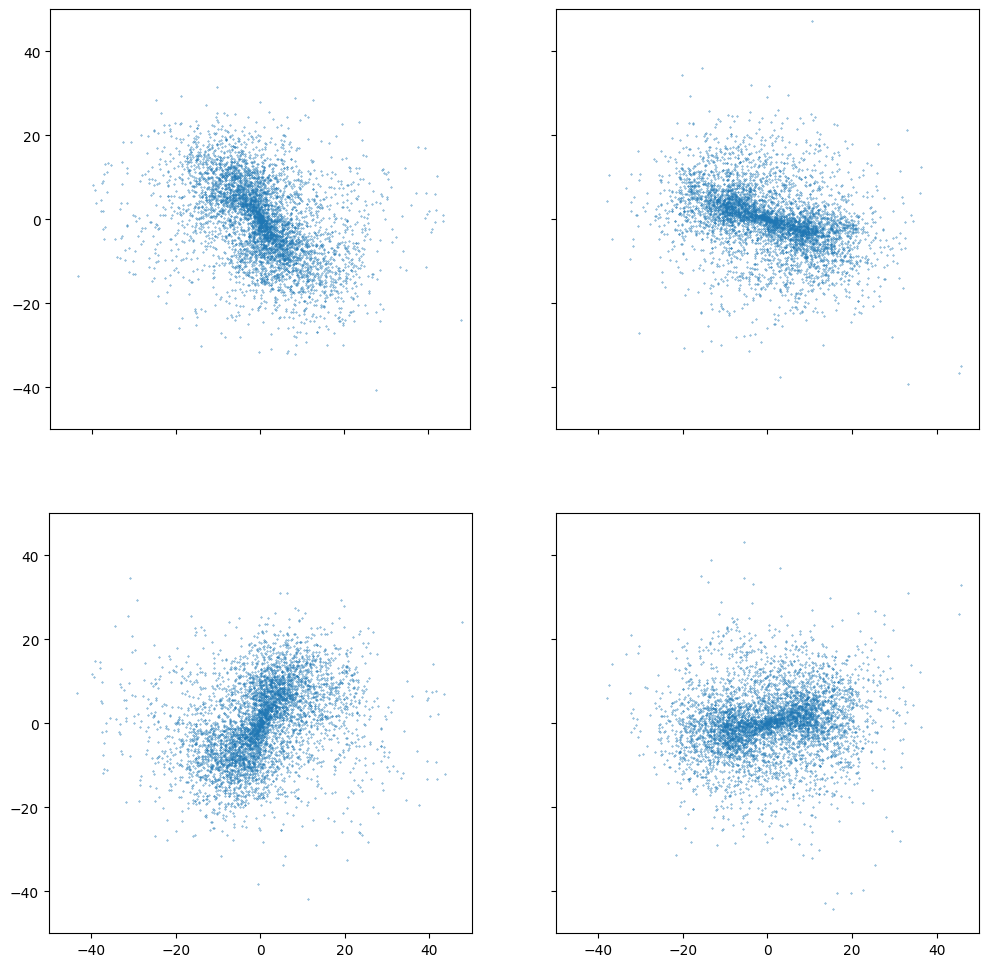

In [8]:
fig, ax = plt.subplots(2, 2, figsize=(12, 12), sharex=True, sharey=True)

sn_ = sn['Naidu21']['lo'][Naidu_idx]
pos_GSE = sn_.part2.pos[in_GSE_RN] - MW_COM_RN
ax[0][0].scatter(pos_GSE[:,0], pos_GSE[:,1], s=0.1)
ax[1][0].scatter(pos_GSE[:,0], pos_GSE[:,2], s=0.1)

sn_ = sn['arepoRN']['lo'][arepo_idx]
pos_GSE = sn_.part2.pos[in_GSE_arepo] - MW_COM_arepo
ax[0][1].scatter(pos_GSE[:,0], pos_GSE[:,1], s=0.1)
ax[1][1].scatter(pos_GSE[:,0], pos_GSE[:,2], s=0.1)

ax[0][0].set_aspect('equal')
ax[0][0].set(xlim=(-50, 50), ylim=(-50, 50))

In [63]:
@njit
def rodrigues_formula(k, v, theta):
    N = v.shape[0]
    v_rot = np.zeros(np.shape(v))
    
    ctheta = np.cos(theta)
    stheta = np.sin(theta)
    
    for i in range(N):
        v_rot[i] = v[i] * ctheta + np.cross(k, v[i]) * stheta + k * (np.dot(k, v[i])) * (1-ctheta)
    
    return v_rot

def get_AngMom(pos, vel, mass, COM, COMV, rcut=8):
    r = np.linalg.norm(pos-COM)
    key = r < rcut
    
    ang = np.cross(pos-COM, vel-COMV)
    ang = np.sum(ang, axis=0)
    ang *= mass
    
    return ang

def get_Lz(sn, sn0, center=np.array([0, 0, 0])):
    
    # plt.scatter(sn_rn0.part2.pos[:,0], sn_rn0.part2.pos[:,1])
    in_MW, in_GSE = get_in_GSE(sn, sn0, center)
    
    pos_MW = sn.part2.pos[in_MW]
    vel_MW = sn.part2.vel[in_MW]
    
    pos_GSE = sn.part2.pos[in_GSE]
    vel_GSE = sn.part2.vel[in_GSE]
    
    MW_COM, MW_COMV, GSE_COM, GSE_COMV = get_COM(sn, sn0, center)
    
    print('GSE_COM', GSE_COM-MW_COM)
    print('GSE_COMV', GSE_COMV-MW_COMV)
    print('MW_COM', MW_COM)
    print('MW_COMV', MW_COMV)
    
    if sn.MassTable[2] > 0:
        mass_GSE = sn.MassTable[2]
    else:
        mass_GSE = sn.part2.mass[in_GSE][0]

    MW_AngMom = get_AngMom(pos_MW, vel_MW, mass_GSE, MW_COM, MW_COMV)

    ang_mom = MW_AngMom
    angmom_dir = ang_mom/np.linalg.norm(ang_mom)
    theta = np.arccos(np.dot(angmom_dir, np.array([0, 0, 1])))
    k = np.cross(ang_mom, np.array([0, 0, 1.]))
    k /= np.linalg.norm(k)
    
    # print('MW_COM', MW_COM)
    # print('MW_COMV', MW_COMV)
    # print('MW_AngMom', MW_AngMom)

    pos_GSE = sn.part2.pos[in_GSE] - MW_COM
    vel_GSE = sn.part2.vel[in_GSE] - MW_COMV
    
    pos_MW = sn.part2.pos[in_MW] - MW_COM
    vel_MW = sn.part2.vel[in_MW] - MW_COMV

    pos_GSE_rot = rodrigues_formula(k, pos_GSE.astype(np.float64), theta)
    vel_GSE_rot = rodrigues_formula(k, vel_GSE.astype(np.float64), theta)
    
    pos_MW_rot = rodrigues_formula(k, pos_MW.astype(np.float64), theta)
    vel_MW_rot = rodrigues_formula(k, vel_MW.astype(np.float64), theta)

    # pos_GSE_rot[:,0] = - pos_GSE_rot[:,0]
    # vel_GSE_rot[:,0] = - vel_GSE_rot[:,0]
    
    Lz = np.cross(pos_GSE_rot, vel_GSE_rot)[:,2]
    
    return Lz, None

GSE_COM [ 0.23925781 -0.24224854 -0.00117493]
GSE_COMV [-24.961687  32.596146 -44.02635 ]
MW_COM [ 239.45764  136.21054 -205.08572]
MW_COMV [ 26.429247   8.822013 -16.96857 ]
GSE_COM [-0.13770919  0.01382856  0.04282159]
GSE_COMV [-34.19169338  -8.54700806   3.89237998]
MW_COM [ 245.11819535  146.52085468 -212.28726839]
MW_COMV [ 26.91498443  13.3442703  -23.38299788]


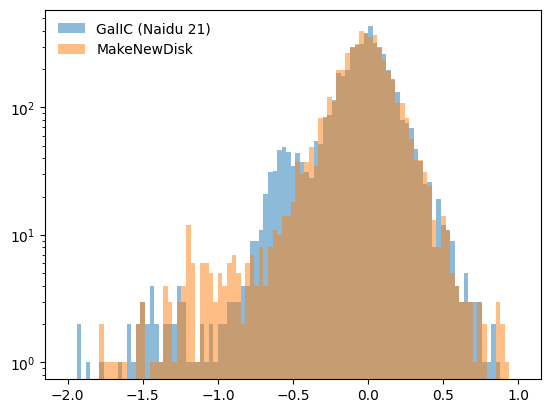

In [64]:
sn_ = sn['Naidu21']['lo'][Naidu_idx]
sn_0 = sn['Naidu21']['lo'][0]
Lz_N, _ = get_Lz(sn_, sn_0)

sn_ = sn['arepoRN']['lo'][arepo_idx]
sn_0 = sn['arepoRN']['lo'][0]
Lz_a, _ = get_Lz(sn_, sn_0)

plt.hist(Lz_N/1E3, bins=np.linspace(-2, 1, 100), alpha=0.5, label='GalIC (Naidu 21)');
plt.hist(Lz_a/1E3, bins=np.linspace(-2, 1, 100), alpha=0.5, label='MakeNewDisk');

# plt.axvline(-0.7)
# plt.axvline(-0.45)
plt.legend(frameon=False)
plt.yscale('log')

GSE_COM [-0.03611714  0.11042999 -0.15930415]
GSE_COMV [  4.11011671 -29.18689529  30.74925196]
MW_COM [ 244.47830384  148.41591422 -211.67728622]
MW_COMV [ 26.02950199  14.00205635 -19.83640391]
GSE_COM [-0.1321492  -0.05628857 -0.1614918 ]
GSE_COMV [-8.10640129 46.06355818  7.91700985]
MW_COM [539.99699848 448.23871409  90.54888154]
MW_COMV [ 29.03688914  15.23474272 -20.6658497 ]
GSE_COM [-0.97432179 -0.59294218  1.46094719]
GSE_COMV [-115.59429739  -93.32820391   40.93584312]
MW_COM [539.92455934 448.236141    90.60471354]
MW_COMV [ 26.81189958  13.25734265 -21.98309843]
GSE_COM [-0.82901774  0.09365645 -0.11872953]
GSE_COMV [ 14.61424352 100.44468778 -99.28972618]
MW_COM [544.46991937 449.38260516  88.37521066]
MW_COMV [ 28.69874231  11.94641591 -22.75476983]


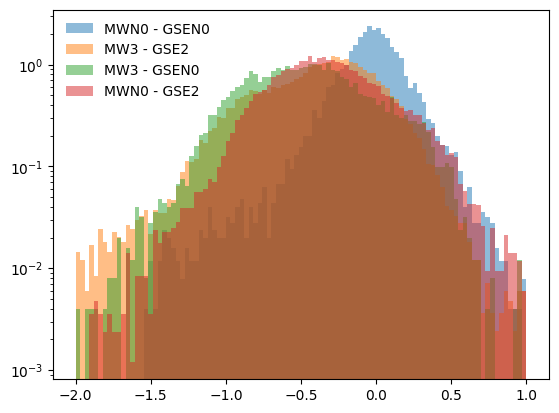

In [70]:
# sn_ = sn['Naidu21']['lo'][Naidu_idx]
# sn_0 = sn['Naidu21']['lo'][0]
# Lz_N, _ = get_Lz(sn_, sn_0)

sn_ = sn['arepoRN']['lo'][arepo_idx]
sn_0 = sn['arepoRN']['lo'][0]
Lz_a, _ = get_Lz(sn_, sn_0)

sn_ = sn['MW3N_GSE2N']['lo'][arepo_idx]
sn_0 = sn['MW3N_GSE2N']['lo'][0]
Lz_MW3_GSE2, _ = get_Lz(sn_, sn_0, center=np.array([300, 300, 300]))

sn_ = sn['MW3N_GSEN0']['lo'][arepo_idx]
sn_0 = sn['MW3N_GSEN0']['lo'][0]
Lz_MW3_GSEN0, _ = get_Lz(sn_, sn_0, center=np.array([300, 300, 300]))

sn_ = sn['MWN0_GSE2N']['lo'][arepo_idx]
sn_0 = sn['MWN0_GSE2N']['lo'][0]
Lz_MWN0_GSE2, _ = get_Lz(sn_, sn_0, center=np.array([300, 300, 300]))

# plt.hist(Lz_N/1E3, bins=np.linspace(-2, 1, 100), alpha=0.5, label='GalIC (Naidu 21)');
plt.hist(Lz_a/1E3, bins=np.linspace(-2, 1, 100), alpha=0.5, label='MWN0 - GSEN0', density=True);
plt.hist(Lz_MW3_GSE2/1E3, bins=np.linspace(-2, 1, 100), alpha=0.5, label='MW3 - GSE2', density=True);
plt.hist(Lz_MW3_GSEN0/1E3, bins=np.linspace(-2, 1, 100), alpha=0.5, label='MW3 - GSEN0', density=True);
plt.hist(Lz_MWN0_GSE2/1E3, bins=np.linspace(-2, 1, 100), alpha=0.5, label='MWN0 - GSE2', density=True);

# plt.axvline(-0.7)
# plt.axvline(-0.45)
plt.legend(frameon=False)
plt.yscale('log')

GSE_COM [-0.29430448 -0.11984729  0.00279785]
GSE_COMV [-66.70978653  12.28064103  13.50092954]
MW_COM [ 187.74730427  120.93086216 -170.56853669]
MW_COMV [ 28.75949895  13.78457734 -20.7711904 ]
GSE_COM [-0.21635402  0.32631759 -0.38841733]
GSE_COMV [-28.04874802 -65.87261963 -24.16026878]
MW_COM [487.34913836 420.76514343 129.86924559]
MW_COMV [ 27.4640255  11.48357105 -19.06786919]


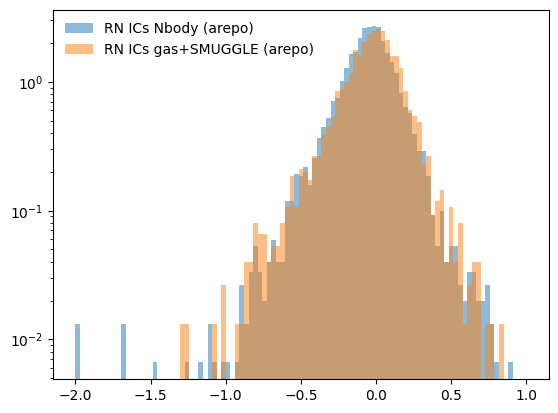

In [76]:
# sn_ = sn['Naidu21']['lo'][Naidu_idx]
# sn_0 = sn['Naidu21']['lo'][0]
# Lz_N, _ = get_Lz(sn_, sn_0)

sn_ = sn['arepoRN']['lo'][arepo_idx]
sn_0 = sn['arepoRN']['lo'][0]
Lz_a, _ = get_Lz(sn_, sn_0)

sn_ = sn['SMUGGLERN']['lo'][arepo_idx]
sn_0 = sn['SMUGGLERN']['lo'][0]
Lz_SMUGGLE, _ = get_Lz(sn_, sn_0, center=np.array([300, 300, 300]))

# plt.hist(Lz_N/1E3, bins=np.linspace(-2, 1, 100), alpha=0.5, label='GalIC (Naidu 21)');
plt.hist(Lz_a/1E3, bins=np.linspace(-2, 1, 100), alpha=0.5, label='RN ICs Nbody (arepo)', density=True);
plt.hist(Lz_SMUGGLE/1E3, bins=np.linspace(-2, 1, 100), alpha=0.5, label='RN ICs gas+SMUGGLE (arepo)', density=True);
# plt.hist(Lz_MW3_GSEN0/1E3, bins=np.linspace(-2, 1, 100), alpha=0.5, label='MW3 - GSEN0', density=True);
# plt.hist(Lz_MWN0_GSE2/1E3, bins=np.linspace(-2, 1, 100), alpha=0.5, label='MWN0 - GSE2', density=True);

# plt.axvline(-0.7)
# plt.axvline(-0.45)
plt.legend(frameon=False)
plt.yscale('log')

### orbit and bound fraction

In [6]:
sn = {}

In [7]:
sn['Naidu21'] = {}

sn['Naidu21']['lo'] = {}

for snap in tqdm(np.arange(0, 101, 2)):
    sn['Naidu21']['lo'][snap] = arepo.Snapshot('/n/holystore01/LABS/conroy_lab/Lab/rnaidu/sims/'+
                                          'z2merger_M1_UM/grid/129_129_50_pro_165/snapshot_'+str(snap).zfill(3))

100%|██████████| 51/51 [00:13<00:00,  3.70it/s]


In [10]:
sn['arepoRN'] = {}
sn['arepoRN']['lo'] = {}

for snap in tqdm(np.arange(0, 2001, 40)):
    sn['arepoRN']['lo'][snap] = arepo.Snapshot(basepath + 'runs/MWN0_GSEN0/lvlRN-nofs/output', snap, combineFiles=True)

100%|██████████| 51/51 [01:14<00:00,  1.46s/it]


In [22]:
sn['adiabatic'] = {}
sn['adiabatic']['lo'] = {}
for snap in tqdm(np.arange(0, 2001, 40)):
    try:
        sn['adiabatic']['lo'][snap] = arepo.Snapshot(basepath + 'runs/MWRNadiso/lvlMNDnofs-GSE/output', snap, combineFiles=True)
    except:
        pass

100%|██████████| 51/51 [06:04<00:00,  7.15s/it]


In [40]:
sn['SMUGGLE'] = {}
sn['SMUGGLE']['lo'] = {}
for snap in tqdm(np.arange(0, 2001, 40)):
    try:
        sn['SMUGGLE']['lo'][snap] = arepo.Snapshot(basepath + 'runs/MWRN_SMUGGLE/lvlRN-nofs/output', snap, combineFiles=True)
    except:
        pass

100%|██████████| 51/51 [00:35<00:00,  1.43it/s]


In [27]:
sn['MNDsoft'] = {}
sn['MNDsoft']['lo'] = {}
for snap in tqdm(np.arange(0, 2001, 40)):
    try:
        sn['MNDsoft']['lo'][snap] = arepo.Snapshot(basepath + 'runs/MWN0_GSEN0/lvlRN-nofs-soft0.0625/output', snap, combineFiles=True)
    except:
        pass

100%|██████████| 51/51 [00:13<00:00,  3.86it/s]


In [77]:
sn['MW3N_GSE2N'] = {}
sn['MW3N_GSE2N']['lo'] = {}
for snap in tqdm(np.arange(0, 2001, 40)):
    try:
        sn['MW3N_GSE2N']['lo'][snap] = arepo.Snapshot(basepath + 'runs/MW3N_GSE2N/lvl4/output', snap, combineFiles=True)
    except:
        pass

100%|██████████| 51/51 [02:07<00:00,  2.50s/it]


In [79]:
sn['MWN0_GSEN0'] = {}
sn['MWN0_GSEN0']['lo'] = {}

for snap in tqdm(np.arange(0, 2001, 40)):
    sn['MWN0_GSEN0']['lo'][snap] = arepo.Snapshot(basepath + 'runs/MWN0_GSEN0/lvl4/output', snap, combineFiles=True)

100%|██████████| 51/51 [02:10<00:00,  2.57s/it]


In [87]:
sn['MW3_MHG0.25_GSE2'] = {}
sn['MW3_MHG0.25_GSE2']['lo'] = {}

for snap in tqdm(np.arange(0, 2001, 40)):
    sn['MW3_MHG0.25_GSE2']['lo'][snap] = arepo.Snapshot(basepath + 'runs/MW3_MHG0.25_GSE2/lvl4/output', snap, combineFiles=True)

 57%|█████▋    | 29/51 [02:01<01:32,  4.19s/it]


Exception: could not detect backend for file '/n/holylfs05/LABS/hernquist_lab/Users/abeane/GSEgas/runs/MW3_MHG0.25_GSE2/lvl4/output', snapshot 1160, filenum None. Specify file format or check file name.

In [12]:
def get_in_GSE(sn, sn0, center=np.array([0, 0, 0])):
    r = np.linalg.norm(sn0.part2.pos - center, axis=1)
    in_GSE0 = r > 40
    in_MW0 = np.logical_not(in_GSE0)
    GSE_ID_min = np.min(sn0.part2.id[in_GSE0])
    GSE_ID_max = np.max(sn0.part2.id[in_GSE0])

    MW_ID_min = np.min(sn0.part2.id[in_MW0])
    MW_ID_max = np.max(sn0.part2.id[in_MW0])
    # print(np.min(sn_rn0.part2.id[in_GSE]), np.max(sn_rn0.part2.id[in_GSE]))
    # print(np.min(sn_rn0.part2.id[in_MW]), np.max(sn_rn0.part2.id[in_MW]))
    
    in_GSE = np.logical_and(sn.part2.id >= GSE_ID_min, sn.part2.id <= GSE_ID_max)
    in_MW = np.logical_and(sn.part2.id >= MW_ID_min, sn.part2.id <= MW_ID_max)
    
    return in_MW, in_GSE

def _get_COM(pos, vel, rmin=1, rmax=20, rfac=0.9):
    COM = np.mean(pos, axis=0)
    r = np.linalg.norm(pos-COM, axis=1)
    
    rcut = rmax
    while rcut > rmin:
        COM = np.mean(pos[r<rcut], axis=0)
        r = np.linalg.norm(pos-COM, axis=1)
        rcut *= rfac
    
    COMV = np.mean(vel[r<rcut], axis=0)
    
    return COM, COMV

def get_COM(sn, sn0, center=np.array([0, 0, 0])):
    
    # plt.scatter(sn_rn0.part2.pos[:,0], sn_rn0.part2.pos[:,1])
    in_MW, in_GSE = get_in_GSE(sn, sn0, center)
    
    pos_MW = sn.part2.pos[in_MW]
    vel_MW = sn.part2.vel[in_MW]
    
    pos_GSE = sn.part2.pos[in_GSE]
    vel_GSE = sn.part2.vel[in_GSE]
    
    MW_COM, MW_COMV = _get_COM(pos_MW, vel_MW)
    GSE_COM, GSE_COMV = _get_COM(pos_GSE, vel_GSE)
    
    return MW_COM, MW_COMV, GSE_COM, GSE_COMV

def get_bound_fraction(sn, sn0, rcut, center=np.array([0, 0, 0])):
    
    MW_COM, _, GSE_COM, _ = get_COM(sn, sn0, center=center)
    in_MW, in_GSE = get_in_GSE(sn, sn0, center)
    
    pos_GSE = sn.part2.pos[in_GSE]
    rGSE = np.linalg.norm(pos_GSE - GSE_COM, axis=1)
    bound = rGSE < rcut
    Nbound = len(np.where(bound)[0])
    NGSE = len(np.where(in_GSE)[0])
    
    return Nbound/NGSE
    

In [14]:
sn['adiabatic']['lo'][0].BoxSize

600. 6.44591e+18 mpc

In [80]:
COM = {}

In [88]:
sn['MW3_MHG0.25_GSE2']['lo'][0].BoxSize

600. 6.44591e+18 mpc

In [89]:
c0 = np.array([0, 0, 0])
c1 = np.array([300, 300, 300])

# for name, center in zip(['Naidu21', 'arepoRN', 'adiabatic', 'SMUGGLE', 'MNDsoft'], [c0, c0, c1, c1, c0]):
# for name, center in zip(['MWN0_GSEN0', 'MW3N_GSE2N', 'MW3_MHG0.25_GSE2'], [c0, c1, c1]):
for name, center in zip(['MW3_MHG0.25_GSE2'], [c1]):
    COM[name] = {}
    COM[name]['Time'] = []
    COM[name]['MW_COM'] = []
    COM[name]['MW_COMV'] = []
    COM[name]['GSE_COM'] = []
    COM[name]['GSE_COMV'] = []
    COM[name]['bound3kpc'] = []
    COM[name]['bound5kpc'] = []
    COM[name]['bound8kpc'] = []

    for snap in tqdm(sn[name]['lo'].keys()):
        sn_ = sn[name]['lo'][snap]
        sn_0 = sn[name]['lo'][0]
    
        MW_COM_, MW_COMV_, GSE_COM_, GSE_COMV_ = get_COM(sn_, sn_0, center=center)
        COM[name]['Time'].append(sn_.Time)
        COM[name]['MW_COM'].append(MW_COM_)
        COM[name]['MW_COMV'].append(MW_COMV_)
        COM[name]['GSE_COM'].append(GSE_COM_)
        COM[name]['GSE_COMV'].append(GSE_COMV_)
    
        bound3kpc_ = get_bound_fraction(sn_, sn_0, 3, center=center)
        bound5kpc_ = get_bound_fraction(sn_, sn_0, 5, center=center)
        bound8kpc_ = get_bound_fraction(sn_, sn_0, 8, center=center)
        COM[name]['bound3kpc'].append(bound3kpc_)
        COM[name]['bound5kpc'].append(bound5kpc_)
        COM[name]['bound8kpc'].append(bound8kpc_)

for i in COM.keys():
    for j in COM[i].keys():
        COM[i][j] = np.array(COM[i][j])

100%|██████████| 29/29 [00:22<00:00,  1.31it/s]


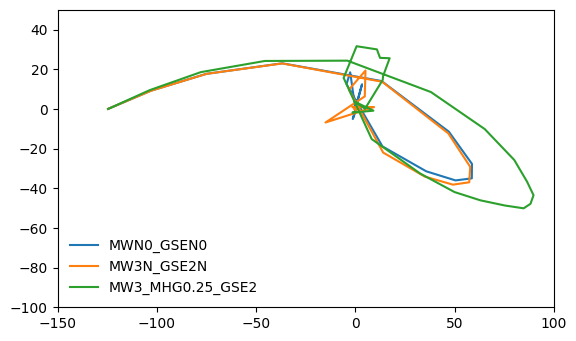

In [90]:
# GSE_center = COM['Naidu21']['GSE_COM'] - COM['Naidu21']['MW_COM']
# # plt.plot(GSE_center[:,0], GSE_center[:,1], label='GalIC (Naidu21)')

# GSE_center = COM['arepoRN']['GSE_COM'] - COM['arepoRN']['MW_COM']
# plt.plot(GSE_center[:,0], GSE_center[:,1], label='MakeNewDisk')

# GSE_center = COM['adiabatic']['GSE_COM'] - COM['adiabatic']['MW_COM']
# # plt.plot(GSE_center[:,0], GSE_center[:,1], label='adiabatic')

# GSE_center = COM['SMUGGLE']['GSE_COM'] - COM['SMUGGLE']['MW_COM']
# plt.plot(GSE_center[:,0], GSE_center[:,1], label='SMUGGLE')

# GSE_center = COM['MNDsoft']['GSE_COM'] - COM['MNDsoft']['MW_COM']
# # plt.plot(GSE_center[:,0], GSE_center[:,1], label='MNDsoft')

GSE_center = COM['MWN0_GSEN0']['GSE_COM'] - COM['MWN0_GSEN0']['MW_COM']
plt.plot(GSE_center[:,0], GSE_center[:,1], label='MWN0_GSEN0')

GSE_center = COM['MW3N_GSE2N']['GSE_COM'] - COM['MW3N_GSE2N']['MW_COM']
plt.plot(GSE_center[:,0], GSE_center[:,1], label='MW3N_GSE2N')

GSE_center = COM['MW3_MHG0.25_GSE2']['GSE_COM'] - COM['MW3_MHG0.25_GSE2']['MW_COM']
plt.plot(GSE_center[:,0], GSE_center[:,1], label='MW3_MHG0.25_GSE2')

plt.legend(frameon=False)
plt.xlim(-150, 100)
plt.ylim(-100, 50)
plt.gca().set_aspect('equal')

Text(0, 0.5, 'bound fraction (r < rcut)')

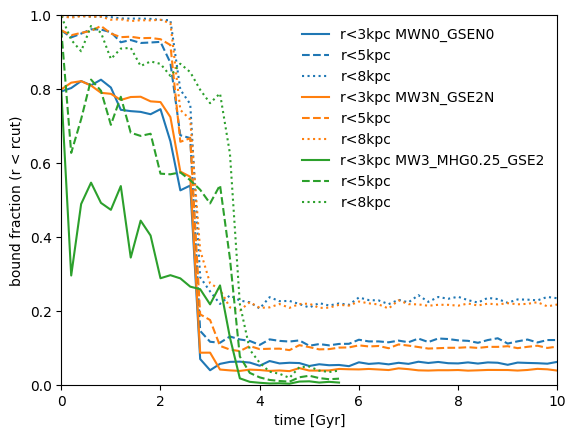

In [91]:
# l = plt.plot(COM['Naidu21']['Time'], COM['Naidu21']['bound3kpc'], label='r<3kpc GalIC (Naidu21)')
# plt.plot(COM['Naidu21']['Time'], COM['Naidu21']['bound5kpc'], 
#              c=l[0].get_color(), ls='dashed', label='r<5kpc')
# plt.plot(COM['Naidu21']['Time'], COM['Naidu21']['bound8kpc'],
#              c=l[0].get_color(), ls='dotted', label='r<8kpc')

# l = plt.plot(COM['arepoRN']['Time'], COM['arepoRN']['bound3kpc'], label='r<3kpc MakeNewDisk')
# plt.plot(COM['arepoRN']['Time'], COM['arepoRN']['bound5kpc'],
#              c=l[0].get_color(), ls='dashed', label='r<5kpc')
# plt.plot(COM['arepoRN']['Time'], COM['arepoRN']['bound8kpc'],
#              c=l[0].get_color(), ls='dotted', label='r<8kpc')

# l = plt.plot(COM['adiabatic']['Time'], COM['adiabatic']['bound3kpc'], label='r<3kpc adiabatic')
# plt.plot(COM['adiabatic']['Time'], COM['adiabatic']['bound5kpc'],
#              c=l[0].get_color(), ls='dashed', label='r<5kpc')
# plt.plot(COM['adiabatic']['Time'], COM['adiabatic']['bound8kpc'],
#              c=l[0].get_color(), ls='dotted', label='r<8kpc')

l = plt.plot(COM['MWN0_GSEN0']['Time'], COM['MWN0_GSEN0']['bound3kpc'], label='r<3kpc MWN0_GSEN0')
plt.plot(COM['MWN0_GSEN0']['Time'], COM['MWN0_GSEN0']['bound5kpc'],
             c=l[0].get_color(), ls='dashed', label='r<5kpc')
plt.plot(COM['MWN0_GSEN0']['Time'], COM['MWN0_GSEN0']['bound8kpc'],
             c=l[0].get_color(), ls='dotted', label='r<8kpc')

l = plt.plot(COM['MW3N_GSE2N']['Time'], COM['MW3N_GSE2N']['bound3kpc'], label='r<3kpc MW3N_GSE2N')
plt.plot(COM['MW3N_GSE2N']['Time'], COM['MW3N_GSE2N']['bound5kpc'],
             c=l[0].get_color(), ls='dashed', label='r<5kpc')
plt.plot(COM['MW3N_GSE2N']['Time'], COM['MW3N_GSE2N']['bound8kpc'],
             c=l[0].get_color(), ls='dotted', label='r<8kpc')

l = plt.plot(COM['MW3_MHG0.25_GSE2']['Time'], COM['MW3_MHG0.25_GSE2']['bound3kpc'], label='r<3kpc MW3_MHG0.25_GSE2')
plt.plot(COM['MW3_MHG0.25_GSE2']['Time'], COM['MW3_MHG0.25_GSE2']['bound5kpc'],
             c=l[0].get_color(), ls='dashed', label='r<5kpc')
plt.plot(COM['MW3_MHG0.25_GSE2']['Time'], COM['MW3_MHG0.25_GSE2']['bound8kpc'],
             c=l[0].get_color(), ls='dotted', label='r<8kpc')

plt.legend(frameon=False)
plt.xlim(0, 10)
plt.ylim(0, 1)
plt.xlabel('time [Gyr]')
plt.ylabel('bound fraction (r < rcut)')


In [ ]:
mbar = 7.5E3 * 8 / 1E10
mdm = 3.75E4 * 8 / 1E10

ics = arepo.Snapshot(basepath + 'ics/MW3N_GSEN0/lvl4/GSE_ICs.dat')

comp_mass = ics.MassTable * ics.NumPart_Total

print('N_HALO', np.round(comp_mass[1]/mdm))
print('N_DISK', np.round(comp_mass[2]/mbar))
print('N_BULGE', np.round(comp_mass[3]/mbar))

N_HALO 716707.0
N_DISK 8348.0
N_BULGE 0.0


GSE_COM [-2.8035583  2.8451385 -2.0517426]
GSE_COMV [ 56.8282  -49.64865  44.3216 ]
MW_COM [ 142.35484    92.319855 -133.79063 ]
MW_COMV [ 26.148523  11.053862 -22.012695]
GSE_COM [ 0.05019997 -0.16311009  0.1116748 ]
GSE_COMV [-12.39272922  14.24270298 -25.42028459]
MW_COM [ 143.79530529   97.96313125 -135.5741191 ]
MW_COMV [ 24.63718127  12.95613957 -21.00549062]
GSE_COM [-0.22571728  0.27297848 -0.25630939]
GSE_COMV [ 34.09510851 -31.11360416  26.59505971]
MW_COM [443.69569392 397.93960084 164.58451916]
MW_COMV [ 26.84895714  14.90991916 -21.006112  ]


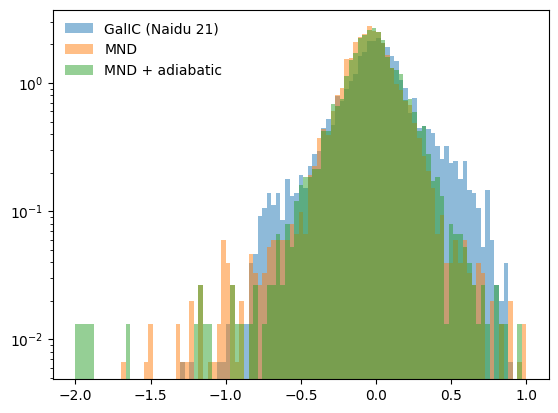

In [50]:
idx = 1280
c0 = np.array([0, 0, 0])
c1 = np.array([300, 300, 300])

sn_ = sn['Naidu21']['lo'][idx//20]
sn_0 = sn['Naidu21']['lo'][0]
Lz_N, _ = get_Lz(sn_, sn_0, center=c0)

sn_ = sn['arepoRN']['lo'][idx]
sn_0 = sn['arepoRN']['lo'][0]
Lz_MND, _ = get_Lz(sn_, sn_0, center=c0)

sn_ = sn['adiabatic']['lo'][idx]
sn_0 = sn['adiabatic']['lo'][0]
Lz_a, _ = get_Lz(sn_, sn_0, center=c1)

plt.hist(Lz_N/1E3, bins=np.linspace(-2, 1, 100), alpha=0.5, label='GalIC (Naidu 21)', density=True);
plt.hist(Lz_MND/1E3, bins=np.linspace(-2, 1, 100), alpha=0.5, label='MND', density=True);
plt.hist(Lz_a/1E3, bins=np.linspace(-2, 1, 100), alpha=0.5, label='MND + adiabatic', density=True);

# plt.axvline(-0.7)
# plt.axvline(-0.45)
plt.legend(frameon=False)
plt.yscale('log')

GSE_COM [ 63.46574   -23.021097    7.3553057]
GSE_COMV [ 43.456642 -54.014793  47.99438 ]
MW_COM [-22.05294   27.421106 -21.921303]
MW_COMV [ 19.759163  32.576603 -38.904934]
GSE_COM [ 58.81584116 -28.02011719  10.64509276]
GSE_COMV [ 27.84271632 -57.96164715  44.16989427]
MW_COM [-20.64072671  27.99834907 -24.26297144]
MW_COMV [ 23.79154784  32.29087656 -34.66774706]
GSE_COM [ 58.8345557  -27.74749096  10.778678  ]
GSE_COMV [ 23.50914192 -52.3645401  46.39704895]
MW_COM [279.28963486 327.95333839 275.76066959]
MW_COMV [ 25.00015831  31.02464676 -37.06248856]


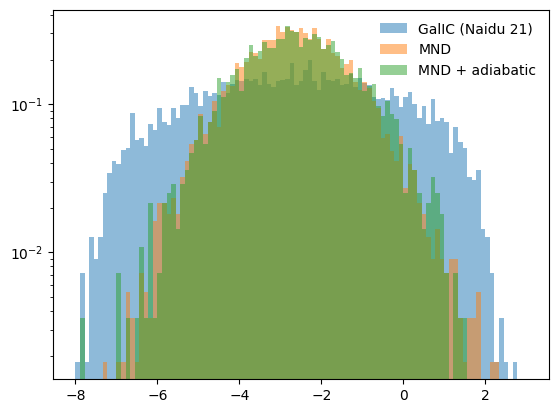

In [54]:
idx = 240
c0 = np.array([0, 0, 0])
c1 = np.array([300, 300, 300])

sn_ = sn['Naidu21']['lo'][idx//20]
sn_0 = sn['Naidu21']['lo'][0]
Lz_N, _ = get_Lz(sn_, sn_0, center=c0)

sn_ = sn['arepoRN']['lo'][idx]
sn_0 = sn['arepoRN']['lo'][0]
Lz_MND, _ = get_Lz(sn_, sn_0, center=c0)

sn_ = sn['SMUGGLE']['lo'][idx]
sn_0 = sn['SMUGGLE']['lo'][0]
Lz_a, _ = get_Lz(sn_, sn_0, center=c1)

bins = np.linspace(-8, 3, 100)
plt.hist(Lz_N/1E3, bins=bins, alpha=0.5, label='GalIC (Naidu 21)', density=True);
plt.hist(Lz_MND/1E3, bins=bins, alpha=0.5, label='MND', density=True);
plt.hist(Lz_a/1E3, bins=bins, alpha=0.5, label='MND + adiabatic', density=True);

# plt.axvline(-0.7)
# plt.axvline(-0.45)
plt.legend(frameon=False)
plt.yscale('log')

In [46]:
1280//20

64